## Initiate Project

In [43]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

RSEED = 42

In [44]:
# Read data
df_tanzania=pd.read_csv("../data/Train_clean.csv")

In [45]:
# As our target is TZN money, function to have custom format to make the plots more readable. 
def thousands_formatter(x, pos):
    return f'{int(x):,}'

## Train-Test Split

In [46]:
# split train-test data. We have dropped:
# Decision to drop also all numerical features, as we do not see correlation, plus other features that don't seem to have an impact on the final cost

X = df_tanzania.drop(['Unnamed: 0','total_cost','ID', "most_impressing", "country",'total_female','total_male','night_mainland', 'night_zanzibar','payment_mode','info_source','purpose','travel_with'],axis=1)
y = df_tanzania.total_cost

In [47]:
X

,age_group,main_activity,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,first_trip_tz
0,45-64,Wildlife tourism,Independent,No,No,No,No,No,No,No,No
1,25-44,Cultural tourism,Independent,No,No,No,No,No,No,No,Yes
2,25-44,Cultural tourism,Independent,No,No,No,No,No,No,No,No
3,25-44,Wildlife tourism,Package Tour,No,Yes,Yes,Yes,Yes,Yes,No,Yes
4,1-24,Wildlife tourism,Independent,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
4380,45-64,Hunting tourism,Independent,No,No,No,No,No,No,No,No
4381,25-44,Wildlife tourism,Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4382,1-24,Wildlife tourism,Independent,No,No,No,No,No,No,No,Yes
4383,25-44,Beach tourism,Independent,Yes,Yes,Yes,No,No,No,No,No


In [48]:


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=RSEED)
# Build new data frame for EDA

df_tanzania_train = X_train.join(y_train)
df_tanzania_test = X_test.join(y_test)

## Feature Engineering - Train

### Encoding

In [49]:
#List of columns
col_encode = ['age_group', 'main_activity', 'tour_arrangement']
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]

In [50]:
# Mapp all Yes/No features (col_map)

def mapping_tanzania(df,cols):
    df[cols] = df[cols].replace({'Yes': 1, 'No': 0}) 

mapping_tanzania(df_tanzania_train,col_map)

In [51]:
# Encode all categorical features (col_encode)
categories = [df_tanzania_train[col].unique() for col in col_encode]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)

In [52]:
df_tanzania_train.shape

(3288, 21)

## Feature Engineering - Test

In [53]:
df_tanzania_test = X_test.join(y_test)

### Encoding

In [54]:
mapping_tanzania(df_tanzania_test,col_map)

In [55]:
# Encode all categorical features (col_encode)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_test[col_encode]) 
t = ohe.transform(df_tanzania_test[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_test_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_test = pd.concat([df_tanzania_test.reset_index(drop=True), df_tanzania_test_encode], axis=1)
df_tanzania_test.drop(columns=col_encode,inplace=True)

In [56]:
# # Create a scaler for total_cost
# scaler_cost = MinMaxScaler()

# # Fit and transform the total_cost column
# scaled_values = scaler_cost.fit_transform(df_tanzania_test[["total_cost"]])

# # Replace the original total_cost column in the DataFrame with the scaled values
# df_tanzania_test["total_cost"] = scaled_values

In [57]:
df_tanzania_train.shape

(3288, 21)

In [58]:
df_tanzania_test.shape

(1097, 21)

# Modeling

In [59]:
X_train = df_tanzania_train.drop("total_cost", axis=1)
y_train = df_tanzania_train["total_cost"]
X_test = df_tanzania_test.drop("total_cost", axis=1)
y_test = df_tanzania_test["total_cost"]

In [60]:
# Define a function to calculate metrics

def evaluate_model(title, model, X_test, y_test):
    """
    Evaluate a model on the test set and print the evaluation metrics.

    Parameters:
        model_name (str): The name of the model to display in the title.
        model: The trained model to evaluate.
        X_test: Test features.
        y_test: True labels for the test set.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics with a title
    print(f"{title} {model}:")
    print(f" - Mean Squared Error (MSE): {mse}")
    print(f" - Root Mean Squared Error (RMSE): {rmse}")
    print(f" - Mean Absolute Error (MAE): {mae}")
    print(f" - R-squared (R²): {r2}\n")

In [61]:
# Define a function to plot actual vs predicted cost
def plot_model_results(model_name, model, y_train, y_pred):
    plt.figure(figsize=(7, 5))
    plt.scatter(y_train, y_pred, color='teal', alpha=0.5)
    plt.plot([0, df_tanzania_train["total_cost"].max()], [0, df_tanzania_train["total_cost"].max()], color='brown', linestyle='--')  # line of perfect predictions (45-degree line)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xlabel('Actual Values (Cost in TZN)')
    plt.ylabel('Actual Values (Cost in TZN)')
    plt.title(f'Predicted vs Actual Values: {model_name}')
    plt.show()

## Model: Decision Tree

In [62]:
# # Initialize baseline model Regressor
model_dt= DecisionTreeRegressor(max_features=2, random_state=RSEED)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_features=2, random_state=42)

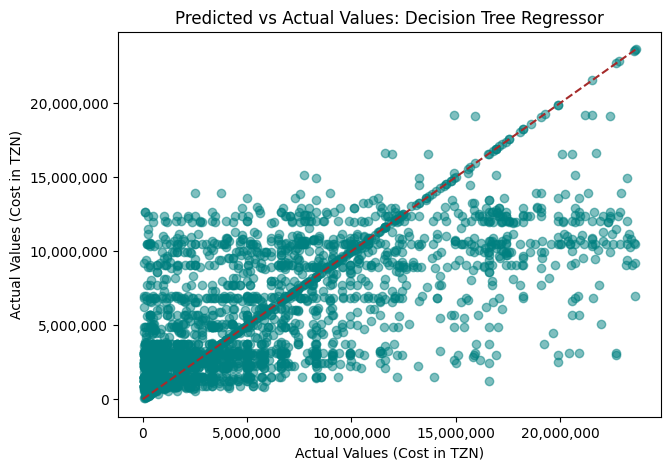

In [63]:
y_pred = model_dt.predict(X_train)
plot_model_results("Decision Tree Regressor", model_dt, y_train, y_pred)

In [64]:
evaluate_model("Train",model_dt, X_train, y_train)
evaluate_model("Test",model_dt, X_test, y_test)

Train DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 15215856372402.783
 - Root Mean Squared Error (RMSE): 3900750.7447160454
 - Mean Absolute Error (MAE): 2611217.966192168
 - R-squared (R²): 0.5187035530109556

Test DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 23960059888320.06
 - Root Mean Squared Error (RMSE): 4894901.417630396
 - Mean Absolute Error (MAE): 3335959.813870393
 - R-squared (R²): 0.25713397044791386



## Model: Linear Models (Linear, Lasso, Ridge)

In [65]:
# # Initialize baseline model Regressor
model_lr= LinearRegression()
model_lr.fit(X_train, y_train)

model_lasso= Lasso()
model_lasso.fit(X_train, y_train)

model_ridge= Ridge()
model_ridge.fit(X_train, y_train)

Ridge()

In [66]:
#evaluate Linear
evaluate_model("Train", model_lr, X_train, y_train)
evaluate_model("Test", model_lr, X_test, y_test)

Train LinearRegression():
 - Mean Squared Error (MSE): 20050010935123.36
 - Root Mean Squared Error (RMSE): 4477723.856506044
 - Mean Absolute Error (MAE): 3227585.257315987
 - R-squared (R²): 0.36579323641167505

Test LinearRegression():
 - Mean Squared Error (MSE): 20269757269442.785
 - Root Mean Squared Error (RMSE): 4502194.716962249
 - Mean Absolute Error (MAE): 3202273.139598002
 - R-squared (R²): 0.371549396248556



In [67]:
#evaluate Lasso
evaluate_model("Train", model_lasso, X_train, y_train)
evaluate_model("Test", model_lasso, X_test, y_test)

Train Lasso():
 - Mean Squared Error (MSE): 20050010936017.945
 - Root Mean Squared Error (RMSE): 4477723.856605937
 - Mean Absolute Error (MAE): 3227583.77298594
 - R-squared (R²): 0.36579323638337813

Test Lasso():
 - Mean Squared Error (MSE): 20269748679703.88
 - Root Mean Squared Error (RMSE): 4502193.76301197
 - Mean Absolute Error (MAE): 3202270.7269981224
 - R-squared (R²): 0.3715496625678083



In [68]:
#evaluate Ridge
evaluate_model("Train", model_ridge, X_train, y_train)
evaluate_model("Test", model_ridge, X_test, y_test)

Train Ridge():
 - Mean Squared Error (MSE): 20050325615756.727
 - Root Mean Squared Error (RMSE): 4477758.994827293
 - Mean Absolute Error (MAE): 3227041.070726642
 - R-squared (R²): 0.3657832826721634

Test Ridge():
 - Mean Squared Error (MSE): 20266980922316.94
 - Root Mean Squared Error (RMSE): 4501886.3737678835
 - Mean Absolute Error (MAE): 3201649.2197837397
 - R-squared (R²): 0.3716354750803973



## Model: Random Forest

In [69]:
model_rf= RandomForestRegressor(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


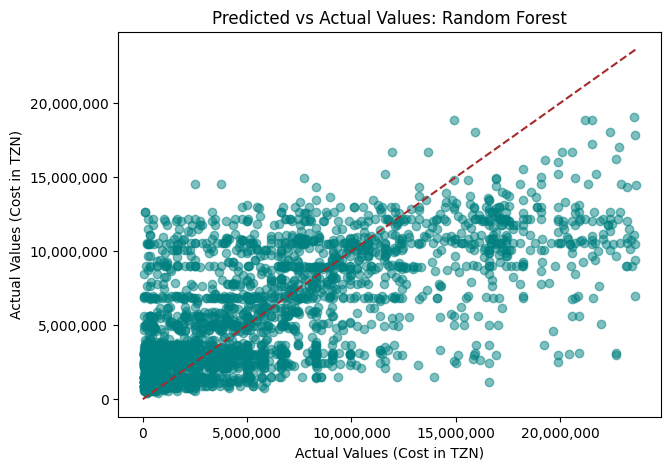

In [70]:
y_pred = model_rf.predict(X_train)
plot_model_results("Random Forest", model_rf, y_train, y_pred)


In [71]:
#evaluate Random Forest
evaluate_model("Train", model_rf, X_train, y_train)
evaluate_model("Test", model_rf, X_test, y_test)

Train RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1):
 - Mean Squared Error (MSE): 15658961736999.027
 - Root Mean Squared Error (RMSE): 3957140.601115789
 - Mean Absolute Error (MAE): 2763469.0375832054
 - R-squared (R²): 0.5046875796472243

Test RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1):
 - Mean Squared Error (MSE): 21405118592319.785
 - Root Mean Squared Error (RMSE): 4626566.609519394
 - Mean Absolute Error (MAE): 3217591.6902218224
 - R-squared (R²): 0.3363482589407236



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## Grid Search Optimisation

In [72]:
param_grid = [
    { 
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":['sqrt', "log2", 2, 3, 5, 8, 10]
    }]


In [73]:

gs = GridSearchCV( 
    estimator=RandomForestRegressor(),
    param_grid= param_grid,
    cv=5,
    verbose=3, 
    error_score='raise',
    n_jobs=-1
)

#fit the model
gs.fit(X_train, y_train)

# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Fitting 5 folds for each of 945 candidates, totalling 4725 fits
Best score: 0.364
Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [74]:
model_rf_1_opt = gs.best_estimator_

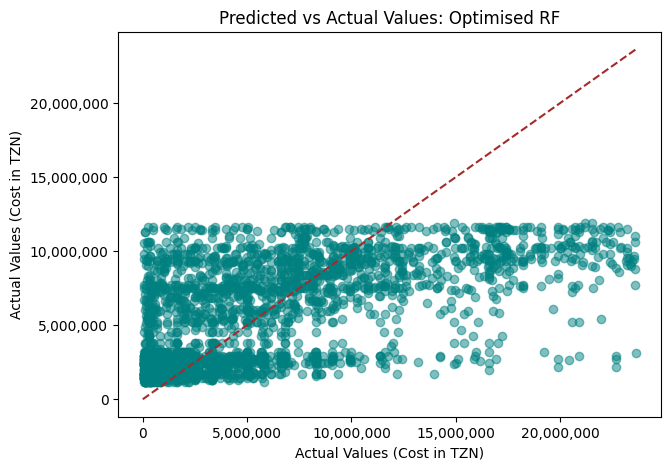

In [75]:
y_pred = model_rf_1_opt.predict(X_train)
plot_model_results("Optimised RF", model_rf_1_opt,y_train,y_pred)

In [76]:
evaluate_model("Train",model_rf_1_opt, X_train, y_train)
evaluate_model("Test",model_rf_1_opt, X_test, y_test)

Train RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5):
 - Mean Squared Error (MSE): 18651063459002.23
 - Root Mean Squared Error (RMSE): 4318687.701027041
 - Mean Absolute Error (MAE): 3088607.7988308943
 - R-squared (R²): 0.4100436836623851

Test RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5):
 - Mean Squared Error (MSE): 19937477895903.7
 - Root Mean Squared Error (RMSE): 4465140.299688656
 - Mean Absolute Error (MAE): 3122974.488904354
 - R-squared (R²): 0.3818515015051194

